## Coverage Pay Projection

Projecting the estimated total cost of coverage pay for the remainder of the 23-24 school year using Meta's Prophet Python Package.

In [2]:
#installing Prophet
!pip install prophet

In [3]:
#importing packages
import pandas as pd 
import matplotlib.pyplot as plt 
import datetime as dt
from prophet import Prophet

In [4]:
#importing Q1 and Q2 Coverage Pay data
Q1 = pd.read_csv(r"C:\Users\togarro\Downloads\Coverage Tracker (Responses) - SQL Coverage Pay Dataset - Q1.csv", parse_dates = ['Date', 'Date of Coverage'] )

Q2 = pd.read_csv(r"C:\Users\togarro\Downloads\Coverage Tracker (Responses) - Coverage Compensation - Q2.csv", parse_dates = ['Date','Date of Coverage'])

#Dropping columns 
Q1 = Q1.drop(columns = ['Email Address', 'Supervisor','Coverage Approval','Approved/Unapproved'])

Q2 = Q2.drop(columns = ['Unnamed: 3', 'Unnamed: 4','Unnamed: 5', 
                        'Reference', 'Approved/Unapproved', 'Coverage Approval',
                        'Supervisor', 'Email Address'])
#concating dataframes
half = pd.concat([Q1,Q2])

In [5]:
#Type of Coverage Data Cleaning
half['Type of Coverage'] = half['Type of Coverage'].replace('Class coverage (long term)','Long Term') 
half['Type of Coverage'] = half['Type of Coverage'].replace('Class coverage (short term)','Short Term')
half['Type of Coverage'] = half['Type of Coverage'].replace('After School Program (Tutoring)','After School Program Tutoring')
half['Type of Coverage'] = half['Type of Coverage'].replace('Non instructional','Non Instructional')

In [6]:
#Name Data Cleaning
half['Name'] = half['Name'].replace('Nikki Waligorski','Nicole Waligorski') 
half['Name'] = half['Name'].replace('Daphnir Cesar Joisil','Daphnir Cesar-Joisil') 

In [7]:
half.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1779 entries, 0 to 1193
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Date                 1779 non-null   datetime64[ns]
 1   Name                 1779 non-null   object        
 2   Employee No          1779 non-null   int64         
 3   Date of Coverage     1779 non-null   datetime64[ns]
 4   Type of Coverage     1779 non-null   object        
 5   Campus               1779 non-null   object        
 6   Number of Coverages  1779 non-null   int64         
 7   Total Compensation   1779 non-null   float64       
dtypes: datetime64[ns](2), float64(1), int64(2), object(3)
memory usage: 125.1+ KB


In [8]:
#defining variable for cutoff date in function
cutoff_date = pd.to_datetime('2023-10-21')

#Creating Quarter column
def quarter(x):
    if x < cutoff_date:
        return 'Q1'
    
    else:
        return 'Q2'
        
half['Quarter'] = half['Date of Coverage'].apply(lambda x: quarter(x))

In [9]:
# #MoM Change
# half['Year-Month'] = half['Date of Coverage'].dt.strftime('%Y-%m')

In [10]:
# Q1 Date Range Validation
Q1 = half[half['Quarter'] == 'Q1']
Q1['Date of Coverage'].agg(['min', 'max'])

min   2023-08-17
max   2023-10-20
Name: Date of Coverage, dtype: datetime64[ns]

In [11]:
#Q2 Date Range Validation
Q2 = half[half['Quarter'] == 'Q2']
Q2['Date of Coverage'].agg(['min', 'max'])

min   2023-10-23
max   2024-01-18
Name: Date of Coverage, dtype: datetime64[ns]

In [12]:
half.shape

(1779, 9)

In [13]:
half[half.duplicated()]

,Date,Name,Employee No,Date of Coverage,Type of Coverage,Campus,Number of Coverages,Total Compensation,Quarter


No duplicates

In [14]:
#Data Cleaning
half['Name'] = half['Name'].str.title()

#Statistical Metrics
round(half.groupby('Name')['Total Compensation'].sum().describe(),2)

count      93.00
mean     1223.00
std      1669.34
min        25.00
25%       150.00
50%       450.00
75%      1445.00
max      7530.00
Name: Total Compensation, dtype: float64

In [15]:
#Creating a Year-Month column
half['Year-Month'] = half['Date of Coverage'].dt.strftime('%Y-%m')

In [16]:
#Grouping Coverage Pay by month
month = half.groupby('Year-Month')['Total Compensation'].sum().reset_index()
month.rename(columns = {'Year-Month':'ds','Total Compensation':'y'},inplace = True)

09:47:50 - cmdstanpy - INFO - Chain [1] start processing
09:47:50 - cmdstanpy - INFO - Chain [1] done processing


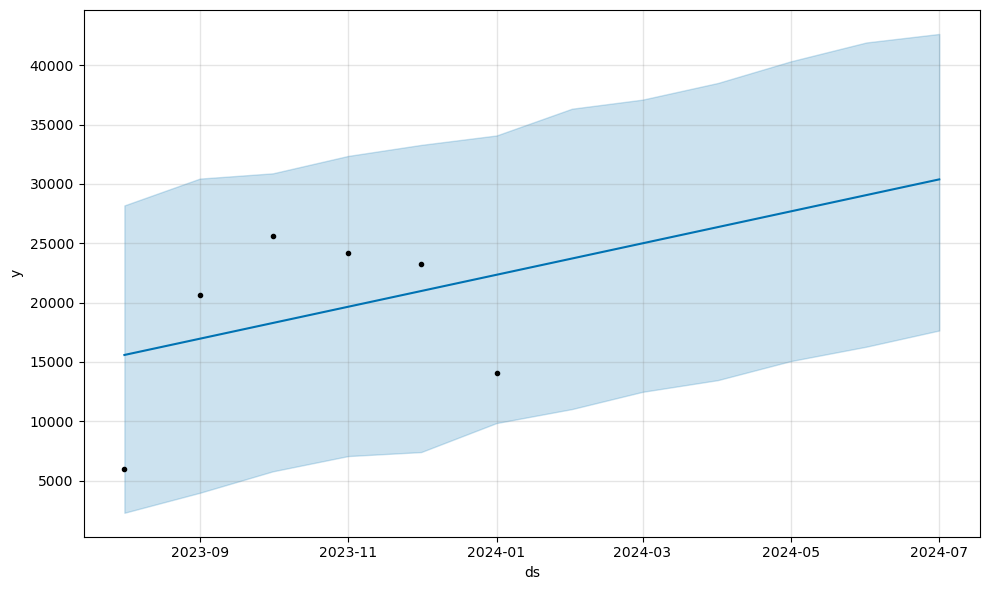

In [17]:
#instantiate prophet object
model = Prophet(interval_width = 0.95)

#fitting model
model.fit(month)

future_month = model.make_future_dataframe(periods = 6, freq = 'MS')

forecast_month = model.predict(future_month)

fig1 = model.plot(forecast_month, uncertainty = True)

plt.show()

In [23]:
coverage_projection = round(forecast_month[['ds','yhat_lower', 'yhat','yhat_upper']],2)
coverage_projection

,ds,yhat_lower,yhat,yhat_upper
0,2023-08-01,2288.34,15583.69,28183.38
1,2023-09-01,3971.40,16952.62,30442.17
2,2023-10-01,5778.29,18277.40,30884.87
3,2023-11-01,7065.10,19646.33,32351.65
4,2023-12-01,7402.00,20971.11,33280.75
5,2024-01-01,9848.64,22340.04,34075.85
6,2024-02-01,11024.43,23708.97,36330.58
7,2024-03-01,12476.69,24989.59,37094.53
8,2024-04-01,13464.69,26358.52,38498.71
9,2024-05-01,15069.89,27683.30,40323.24


In [21]:
# coverage_projection.to_csv('Coverage Pay Projection.csv', index = False, header = True,encoding = 'utf-8' )

The values above reflect a confidence interval of 95%, meaning that there is a 95% chance that the values will fall in the range of the predicted values based on the model.